# Exploration of PISA data
## by Corey Punches

## Table of Contents
- [Introduction](#intro)
- [Gather/Assess/Clean](#gather)
- [Analyze - Univariate](#univariate)
- [Analyze - Bivariate](#bivariate)
- [Analyze - Multivariate](#multivariate)
- [Summary](#Summary)  
- [Resources](#resources)

<a id='intro'></a>
## Preliminary Wrangling

PISA is a survey of students' skills and knowledge as they
approach the end of compulsory education. It is not a
conventional school test. Rather than examining how well
students have learned the school curriculum, it looks at how
well prepared they are for life beyond school.
Around 510,000 students in 65 economies took part in the
PISA 2012 assessment of reading, mathematics and science
representing about 28 million 15-year-olds globally. Of those
economies, 44 took part in an assessment of creative problem
solving and 18 in an assessment of financial literacy.

#### Some questions I will be exploring are

- Are there differences in math achievement based on gender,or student anxiety?

- Does there exist inequality in academic achievement?

In [1]:
# import all packages and set plots to be embedded inline
import math
import tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib.lines import Line2D

rcParams['figure.figsize'] = 15, 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

We will load the data from the pisa2012.csv file into a Pandas datafarme object. This is a large file with 636 columns. We don't need all of the columns for the analysis so rather than dropping after load, we'll save ~8GB of RAM by only reading in the columns we need on the front end. We'll also rename the columns to something more understandable.

<a id='gather'></a>

In [2]:
# read only specified columns from file
pisa_df = pd.read_csv('data/pisa2012.csv', encoding='latin-1',low_memory=False,
                     usecols=[1,12,70,89,90,91,93,96,98,501])
# rename columns
pisa_df.columns = ['country','gender','enjoy_math','ma_worry_that_difficult','msc_worry_not_good_at',
                   'ma_get_tense','ma_get_nervous','ma_feel_helpless','ma_worry_about_poor_grades','math_score']


In [3]:
# high-level overview of data shape and composition
print(pisa_df.shape)
print(pisa_df.dtypes)
pisa_df.head(10)

(485490, 10)
country                        object
gender                         object
enjoy_math                     object
ma_worry_that_difficult        object
msc_worry_not_good_at          object
ma_get_tense                   object
ma_get_nervous                 object
ma_feel_helpless               object
ma_worry_about_poor_grades     object
math_score                    float64
dtype: object


,country,gender,enjoy_math,ma_worry_that_difficult,msc_worry_not_good_at,ma_get_tense,ma_get_nervous,ma_feel_helpless,ma_worry_about_poor_grades,math_score
0,Albania,Female,Agree,Agree,Disagree,Agree,Agree,Disagree,Disagree,406.8469
1,Albania,Female,Disagree,NaN,NaN,NaN,NaN,NaN,NaN,486.1427
2,Albania,Female,Agree,NaN,NaN,NaN,NaN,NaN,NaN,533.2684
3,Albania,Female,NaN,NaN,Strongly agree,Disagree,Agree,Disagree,Agree,412.2215
4,Albania,Female,Disagree,Strongly agree,Strongly agree,Agree,Strongly agree,Disagree,Agree,381.9209
5,Albania,Female,NaN,Disagree,Disagree,Disagree,Agree,Disagree,Disagree,396.3312
6,Albania,Female,NaN,Agree,Agree,Strongly agree,Disagree,Disagree,Agree,438.0823
7,Albania,Male,Agree,Disagree,Agree,Disagree,Disagree,Agree,Agree,576.5773
8,Albania,Female,Agree,Agree,Agree,Agree,Agree,Strongly disagree,Disagree,434.1097
9,Albania,Female,NaN,Strongly disagree,Strongly disagree,Disagree,Disagree,Strongly disagree,Strongly disagree,463.6314


In [4]:
pisa_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 10 columns):
country                       485490 non-null object
gender                        485490 non-null object
enjoy_math                    314737 non-null object
ma_worry_that_difficult       313855 non-null object
msc_worry_not_good_at         313502 non-null object
ma_get_tense                  312176 non-null object
ma_get_nervous                312624 non-null object
ma_feel_helpless              312456 non-null object
ma_worry_about_poor_grades    312853 non-null object
math_score                    485490 non-null float64
dtypes: float64(1), object(9)
memory usage: 238.4 MB


In [5]:
for dtype in ['float64','int64','object']:
    selected_dtype = pisa_df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for float64 columns: 1.85MB
Average memory usage for int64 columns: 0.00MB
Average memory usage for object columns: 23.47MB


In [6]:
# This is a large dataset and want to know memory usage in case we need to optimize usage
# so create a function
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
        
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [8]:
pisa_float = pisa_df.select_dtypes(include=['float64']).copy()
pisa_float.describe()

,math_score
count,485490.000000
mean,469.621653
std,103.265391
min,19.792800
25%,395.318600
50%,466.201900
75%,541.057800
max,962.229300


In [9]:
print(mem_usage(pisa_float))

3.70 MB


In [10]:
pisa_obj = pisa_df.select_dtypes(include=['object']).copy()
pisa_obj.describe()

,country,gender,enjoy_math,ma_worry_that_difficult,msc_worry_not_good_at,ma_get_tense,ma_get_nervous,ma_feel_helpless,ma_worry_about_poor_grades
count,485490,485490,314737,313855,313502,312176,312624,312456,312853
unique,68,2,4,4,4,4,4,4,4
top,Mexico,Female,Disagree,Agree,Disagree,Disagree,Disagree,Disagree,Agree
freq,33806,245064,116952,134489,118658,135714,140694,144420,117927


In [11]:
print(mem_usage(pisa_obj))

234.68 MB


Change the nans in the object columns to somthing useful, like no answer

In [12]:
pisa_df = pisa_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('No Answer'))

All of the remaining object type columns can be converted to categorical variables. The memory savings should be significant, and it may make some analysis easier.

In [13]:
# convert object types that are not already converted to 0,1 to categorical type
ordinal_var_dict = {'gender':['Female', 'Male'],
                    'ma_worry_that_difficult':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    'msc_worry_not_good_at':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    'ma_get_tense':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    'ma_get_nervous':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    'ma_feel_helpless':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    'ma_worry_about_poor_grades':['No Answer','Strongly disagree','Disagree','Agree','Strongly agree'],
                    }

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    pisa_df[var] = pisa_df[var].astype(ordered_var)

In [14]:
pisa_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 10 columns):
country                       485490 non-null object
gender                        485490 non-null category
enjoy_math                    485490 non-null object
ma_worry_that_difficult       485490 non-null category
msc_worry_not_good_at         485490 non-null category
ma_get_tense                  485490 non-null category
ma_get_nervous                485490 non-null category
ma_feel_helpless              485490 non-null category
ma_worry_about_poor_grades    485490 non-null category
math_score                    485490 non-null float64
dtypes: category(7), float64(1), object(2)
memory usage: 67.8 MB


### Dataset Structure

There are 485,490 rows of student data with 636 columns. The dataset has been pared down to the 6 columns of qualitative categorical data which have been made into ordered factor variables of multiple levels as shown below.

- ['No Answer','Strongly disagree','Disagree','Agree','Strongly agree']
    
There are 1 numeric columns in the dataset, and 1 string object.

### Main feature(s) of interest

I'm interested in determining if student anxiety, or perceived anxiety, plays a part in academic achievement - specifically the students math scores; also are there differences between genders in math scores and anxiety. 

### Features in the dataset to help support investigation into feature(s) of interest

Math score, gender, and the features:
- ma_get_tense                   
>Math anxiety - math makes student feel tense
- ma_get_nervous                 
>Math anxiety - math makes student feel nervous
- ma_feel_helpless               
>Math anxiety - math makes student feel helpless
- ma_worry_about_poor_grades     
>Math anxiety - student worries about making good grades
- msc_worry_not_good_at          
>Math anxiety - student worries they are not good at math
- ma_worry_that_difficult        
>Math anxiety - student worries that math is too difficult for them

will be the most important in finding answers to my questions. *note that I have included msc_worry_not_good as an anxiety measure as it seemed applicable*

## Univariate Exploration
<a id='univariate'></a>
Examine Math, Reading, and Science scores for all students in dataset

In [15]:
pisa_df.math_score.describe()

count    485490.000000
mean        469.621653
std         103.265391
min          19.792800
25%         395.318600
50%         466.201900
75%         541.057800
max         962.229300
Name: math_score, dtype: float64

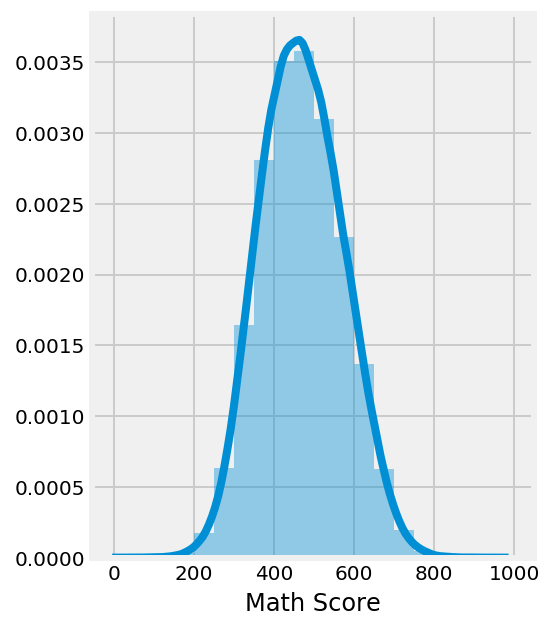

In [16]:
# produce a side-by-side comparison of the distribution of math, reading, and science scores in dataset
binsize = 50

plt.figure(figsize=[12, 5])
# left plot - math scores
bins = np.arange(0, pisa_df['math_score'].max()+binsize, binsize)
plt.subplot(1, 3, 1)
sb.distplot(pisa_df.math_score, bins=bins)
plt.xlabel('Math Score');

#### Distribution of scores appears normal across entire population

Now take a look at some of the qualatative variables

In [17]:
def plotCat(data, cat, ylabel='', xlabel='', title=''):
    # use the supplied dataframe to generate a bar chart of categorical values
    base_color = sb.color_palette()[0]
    sb.countplot(data=data, x=cat, color=base_color)

    # add annotations
    n_points = data.shape[0]
    cat_counts = data[cat].value_counts()
    locs, labels = plt.xticks() # get current location of the ticks and labels

    # loop through each pair of loc and label
    for loc, label in zip(locs, labels):
        # get text property of label
        count = cat_counts[label.get_text()]
        if count < 100000:
            minus_per = math.ceil(count * .20) # the adjustment to text location differs based on total
        else:
            minus_per = math.ceil(count * .08)
        pct_string = '{:0.2f}%'.format(100*count/n_points)
        # print annotation just below top of bar
        plt.text(loc, count-minus_per, pct_string, ha='center', color='w', fontweight='bold')
    
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
        
    return

### Roughly 65% of respondents answered the more subjective questions, we should look at the proportions of the answers where the respondents answered the questions

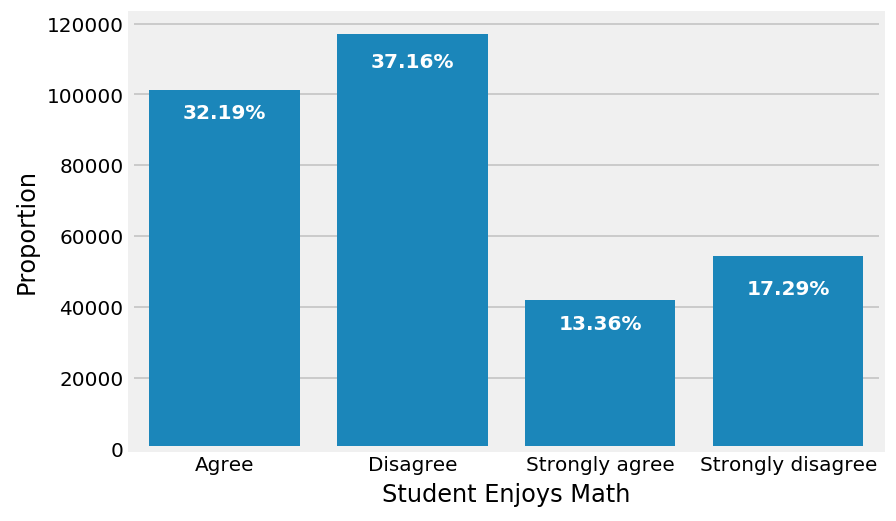

In [18]:
plotCat(pisa_df.query('enjoy_math != "No Answer"'),'enjoy_math','Proportion','Student Enjoys Math')

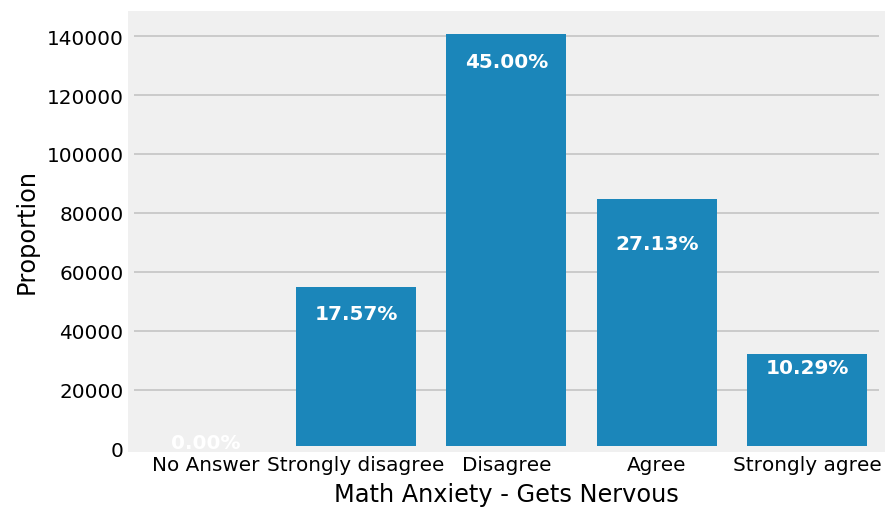

In [19]:
plotCat(pisa_df.query('ma_get_nervous != "No Answer"'),'ma_get_nervous','Proportion','Math Anxiety - Gets Nervous')

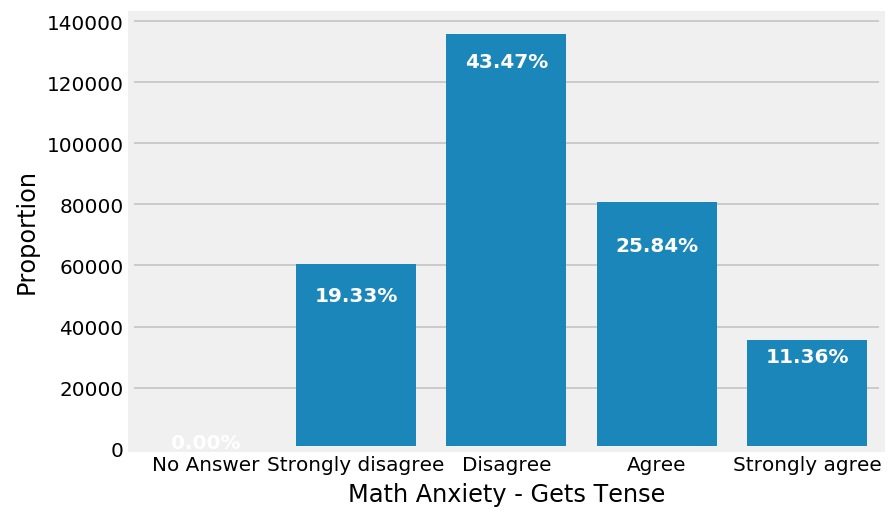

In [20]:
plotCat(pisa_df.query('ma_get_tense != "No Answer"'),'ma_get_tense','Proportion','Math Anxiety - Gets Tense')

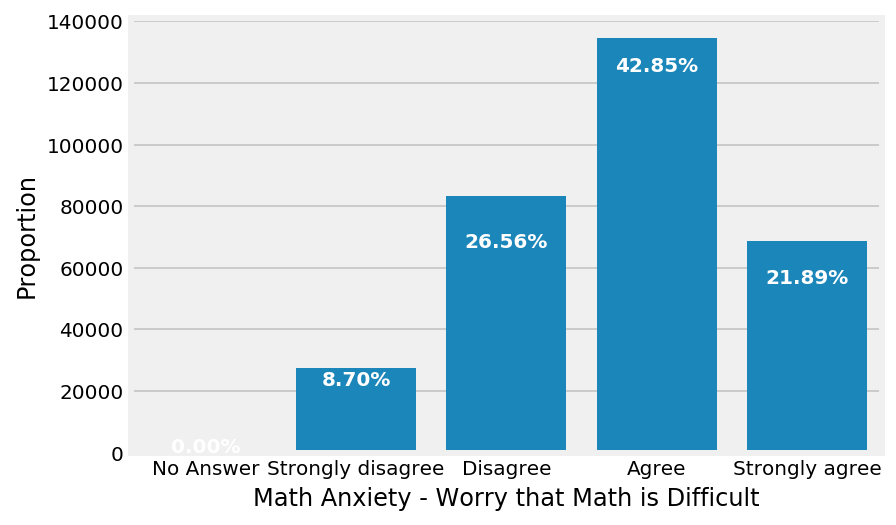

In [21]:
plotCat(pisa_df.query('ma_worry_that_difficult != "No Answer"'),'ma_worry_that_difficult','Proportion',
        'Math Anxiety - Worry that Math is Difficult')

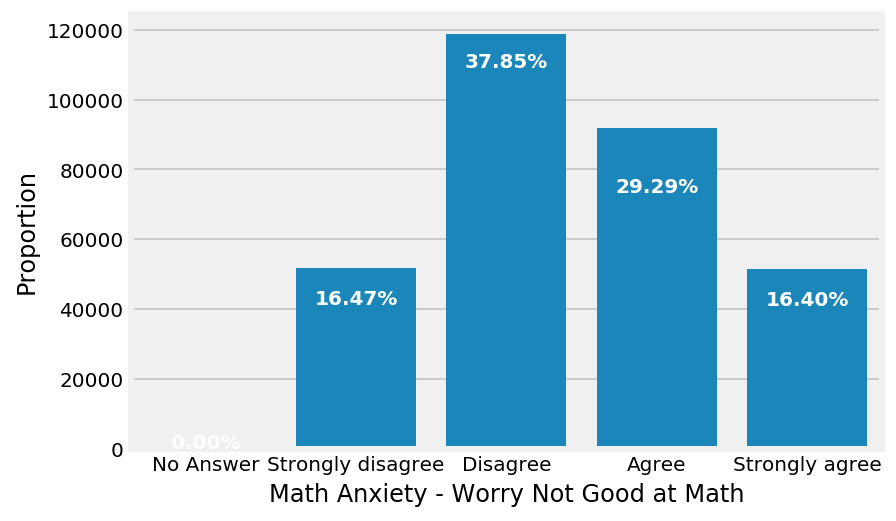

In [22]:
plotCat(pisa_df.query('msc_worry_not_good_at != "No Answer"'),'msc_worry_not_good_at','Proportion',
        'Math Anxiety - Worry Not Good at Math')

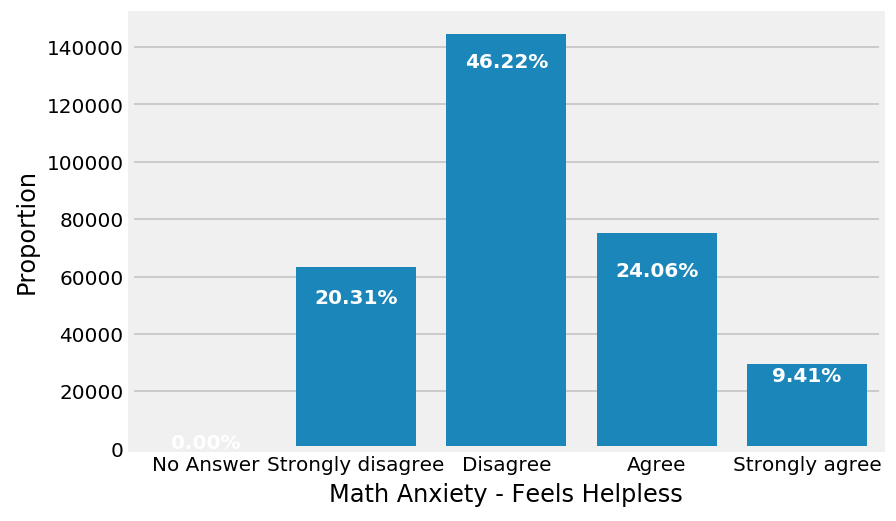

In [23]:
plotCat(pisa_df.query('ma_feel_helpless != "No Answer"'),'ma_feel_helpless','Proportion',
        'Math Anxiety - Feels Helpless')

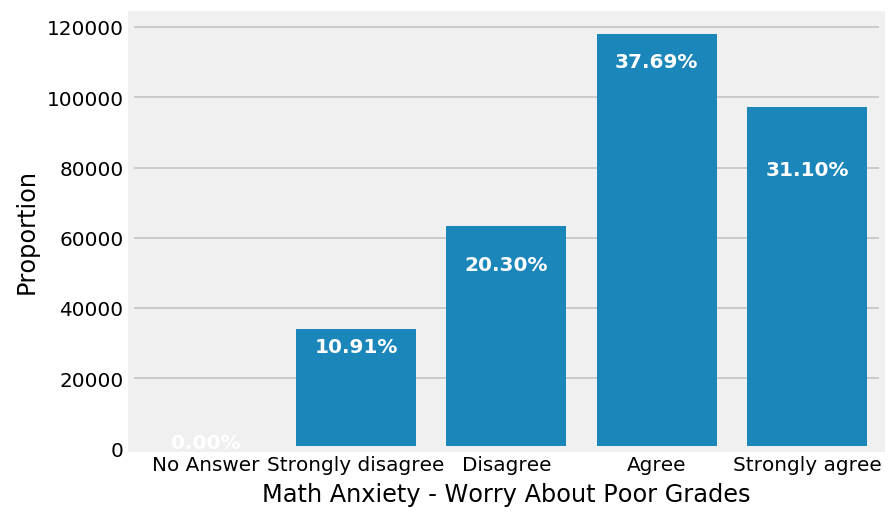

In [24]:
plotCat(pisa_df.query('ma_worry_about_poor_grades != "No Answer"'),'ma_worry_about_poor_grades','Proportion',
        'Math Anxiety - Worry About Poor Grades')

#### Proportions of responses seem reasonable as the strong aggreements and strong disagreements have the lowest proportion except when asking about worrying about bad grades, there seems to be a lot of strong agreement in terms of worrying about getting good grades in math.

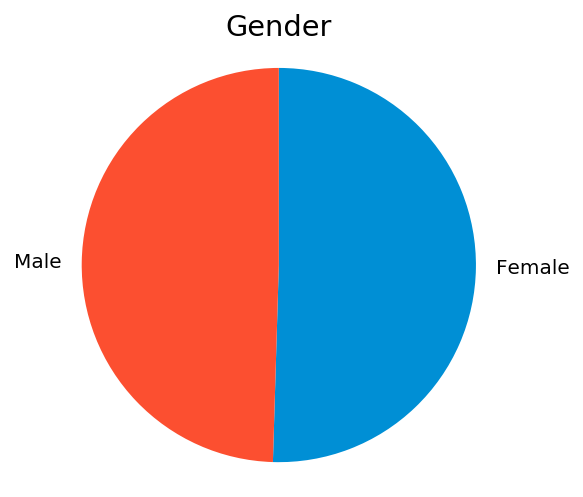

In [25]:
plt.pie(pisa_df['gender'].value_counts(), labels=pisa_df['gender'].value_counts().index,startangle=90,counterclock=False)
plt.axis('square')
plt.title('Gender');

In [26]:
print('Male Students: {:.2f}%'.format(pisa_df['gender'].value_counts()['Male']/pisa_df.shape[0]))
print('Female Students: {:.2f}%'.format(pisa_df['gender'].value_counts()['Female']/pisa_df.shape[0]))

Male Students: 0.50%
Female Students: 0.50%


### A univariate exploration didn't uncover any unexpected data, the data is split evenly between male and female students, the distribuition of scores is normal, and answers regarding student anxiety does not appear to have any major issues.



## Bivariate Exploration
<a id='bivariate'></a>
Now explore whether anxiety has any bearing on the breakdown of answers, or test scores, or if gender has a direct relationship to scores.

In [27]:
def vioplot(data, x, y, ylabel='', xlabel='',inner=None, title=None):
    # use the supplied dataframe to generate a violin chart of values
    base_color = sb.color_palette()[0]
    sb.violinplot(data=data, x=x, y=y, color=base_color, inner=inner)
    
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if title:
        plt.title(title);
        
    return

In [28]:
def bxplot(data, x, y, ylabel='', xlabel='', title=None):
    # use the supplied dataframe to generate a boxplot chart of values
    base_color = sb.color_palette()[0]
    sb.boxplot(data=data, x=x, y=y, color=base_color)
    
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if title:
        plt.title(title);
        
    return

In [29]:
def barplot(data, x, y, ylabel='', xlabel='', title=None):
    # use the supplied dataframe to generate a barplot chart of values
    base_color = sb.color_palette()[0]
    ax = sb.countplot(data=data,x=x, hue=y, color=base_color);
    ax.legend(loc=2, ncol=5, framealpha=1);
    
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if title:
        plt.title(title);
        
    return

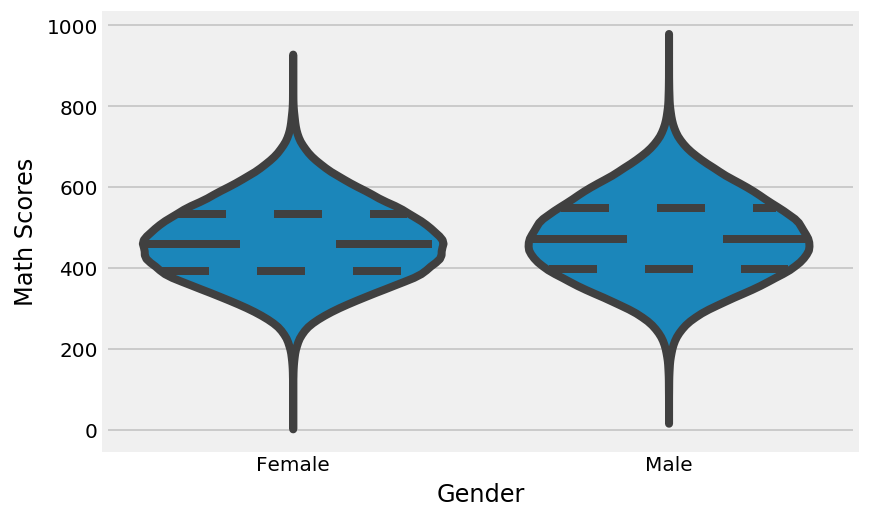

In [30]:
vioplot(pisa_df,'gender','math_score','Math Scores','Gender','quartile')

### There appears to be a slight difference in scores based on gender.

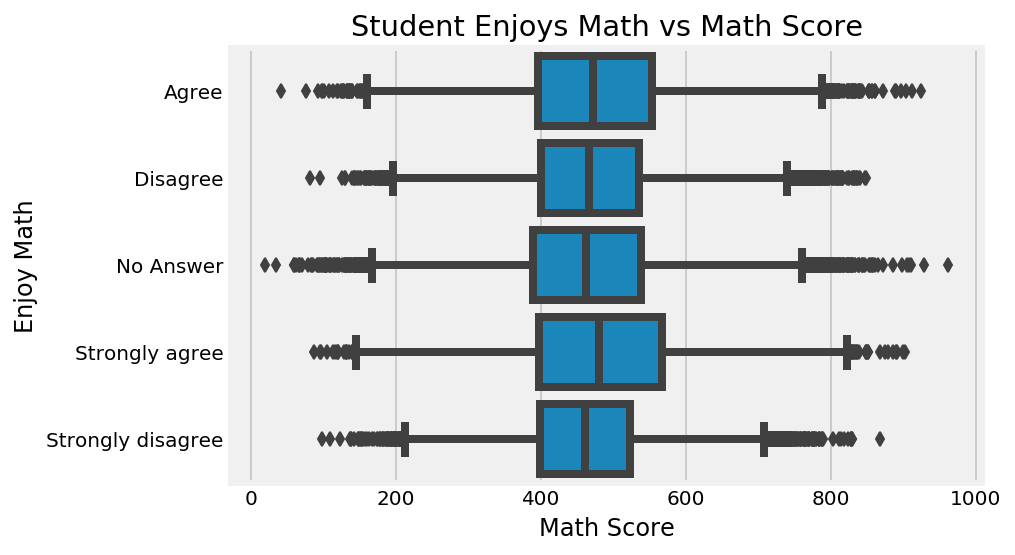

In [32]:
bxplot(pisa_df, 'math_score', 'enjoy_math', 'Enjoy Math', 'Math Score', 'Student Enjoys Math vs Math Score');


### Interesting, the student self identification as to whether they do or do not enjoy math does seem to be reflected in the scores - the students claiming to not enjoy math have done slightly less as well as the students who claim to enjoy math. 

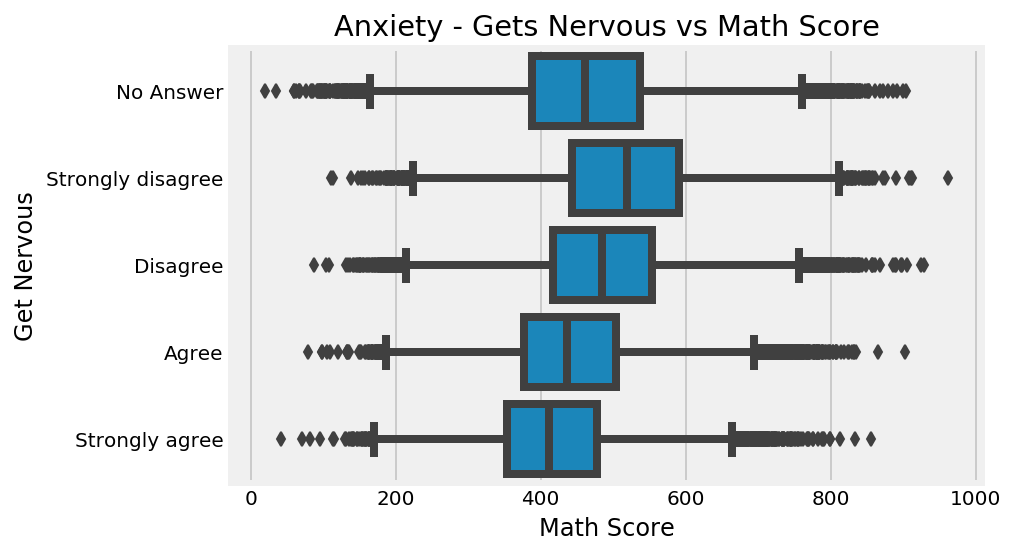

In [33]:
bxplot(pisa_df, 'math_score', 'ma_get_nervous', 'Get Nervous', 'Math Score', 'Anxiety - Gets Nervous vs Math Score');

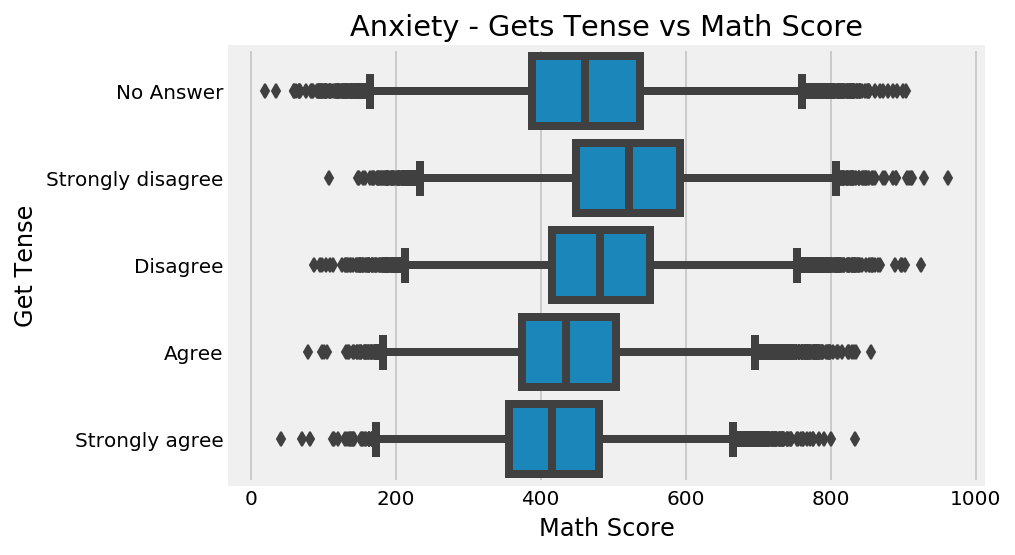

In [34]:
bxplot(pisa_df, 'math_score', 'ma_get_tense', 'Get Tense', 'Math Score', 'Anxiety - Gets Tense vs Math Score');

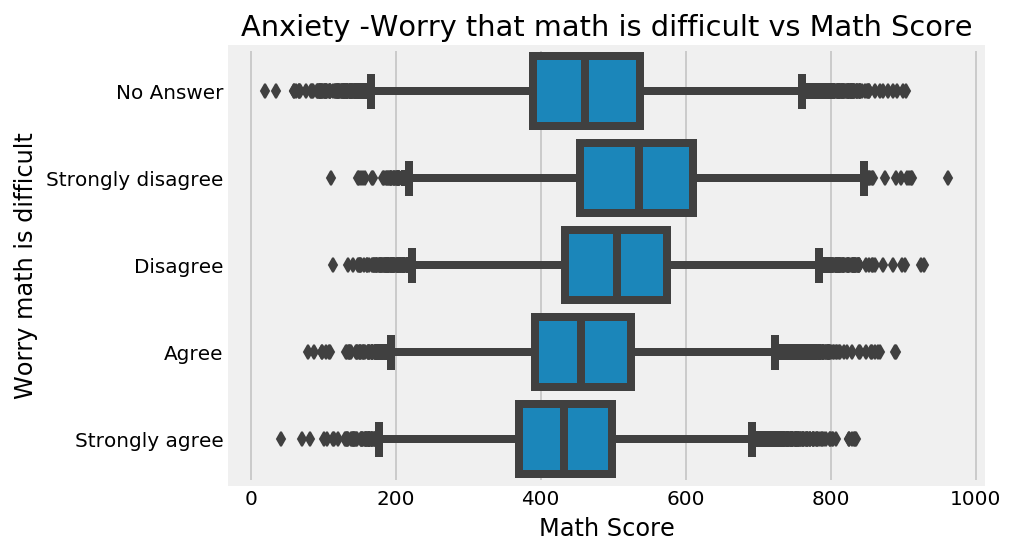

In [35]:
bxplot(pisa_df, 'math_score', 'ma_worry_that_difficult', 'Worry math is difficult', 
       'Math Score', 'Anxiety -Worry that math is difficult vs Math Score');

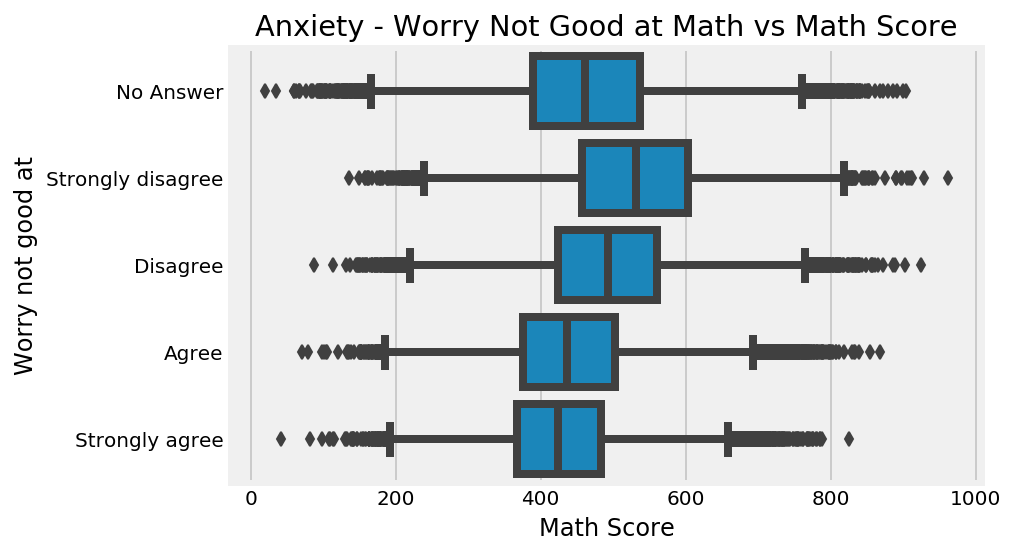

In [36]:
bxplot(pisa_df, 'math_score', 'msc_worry_not_good_at', 'Worry not good at', 
       'Math Score', 'Anxiety - Worry Not Good at Math vs Math Score');

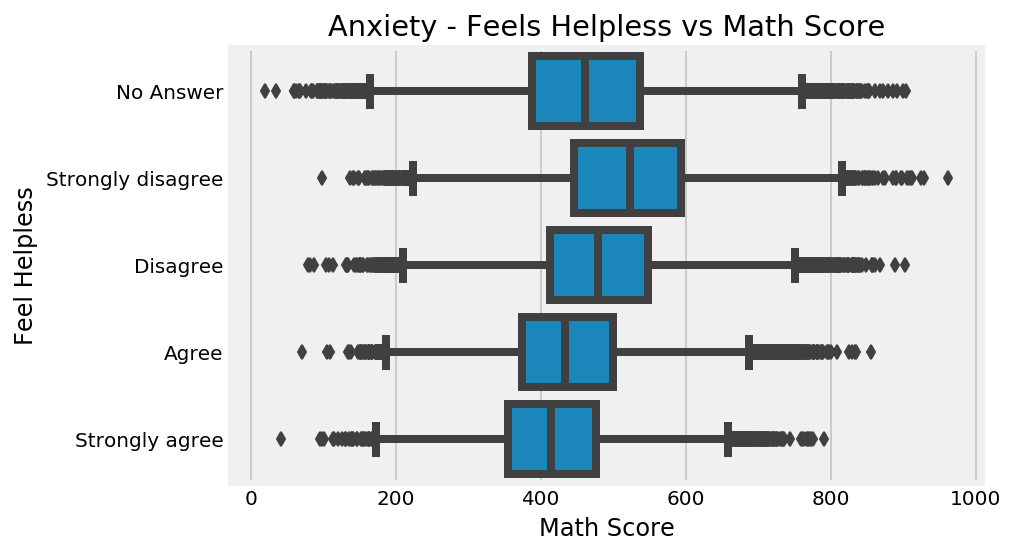

In [37]:
bxplot(pisa_df, 'math_score', 'ma_feel_helpless', 'Feel Helpless', 
       'Math Score', 'Anxiety - Feels Helpless vs Math Score');

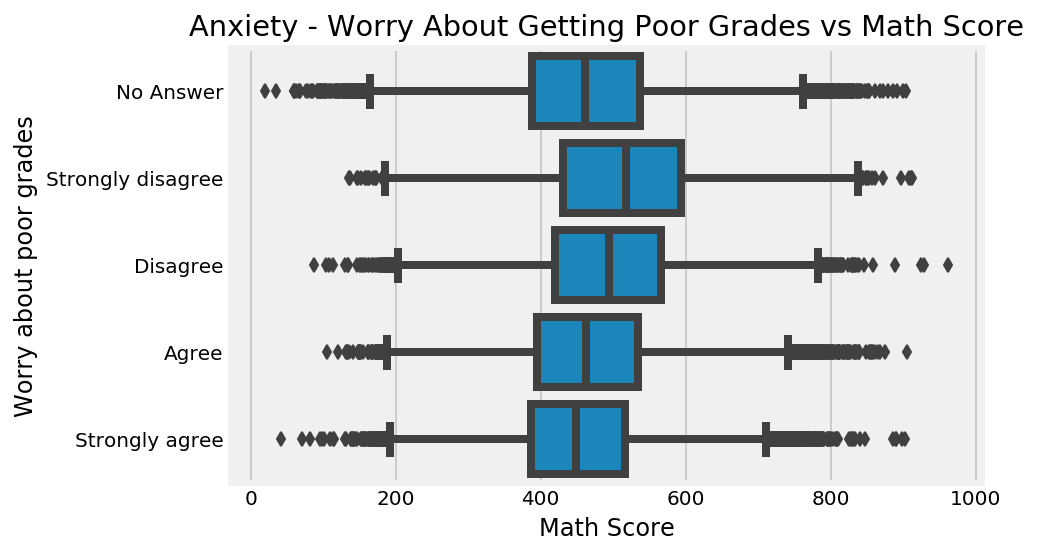

In [38]:
bxplot(pisa_df, 'math_score', 'ma_worry_about_poor_grades', 'Worry about poor grades', 
       'Math Score', 'Anxiety - Worry About Getting Poor Grades vs Math Score');

#### Examine if gender plays a role in the frequency of positive response to anxiety questions

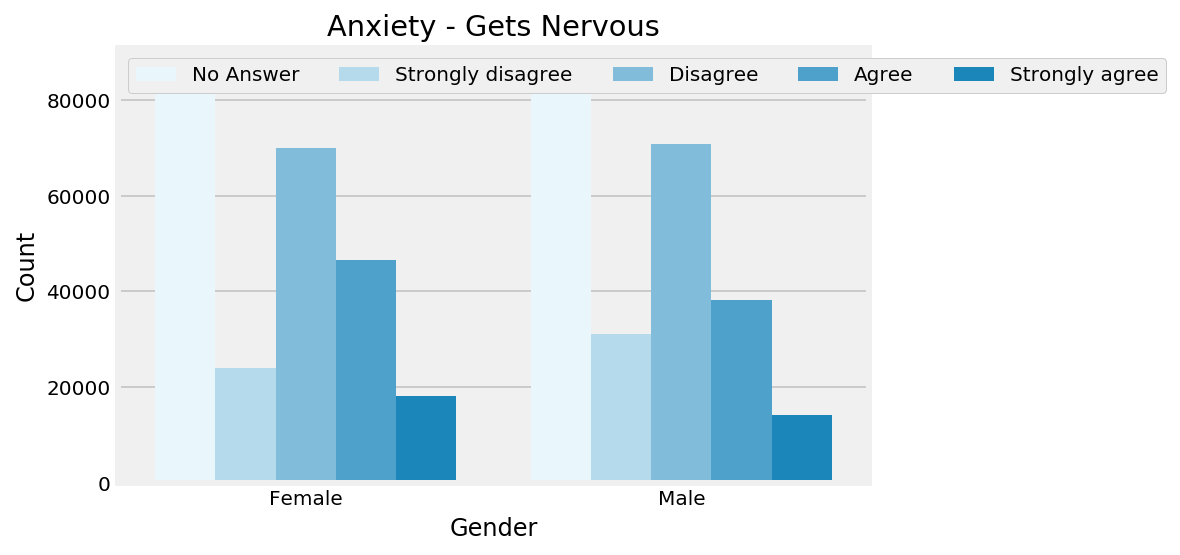

In [39]:
barplot(pisa_df, 'gender', 'ma_get_nervous', 'Count', 'Gender', 'Anxiety - Gets Nervous')

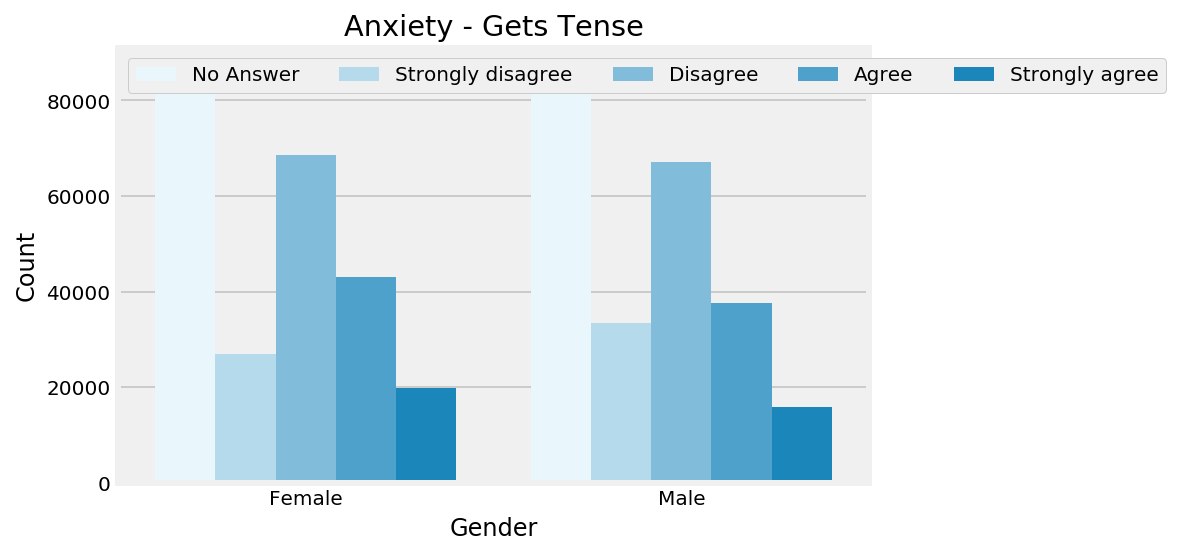

In [40]:
barplot(pisa_df, 'gender', 'ma_get_tense', 'Count', 'Gender', 'Anxiety - Gets Tense')

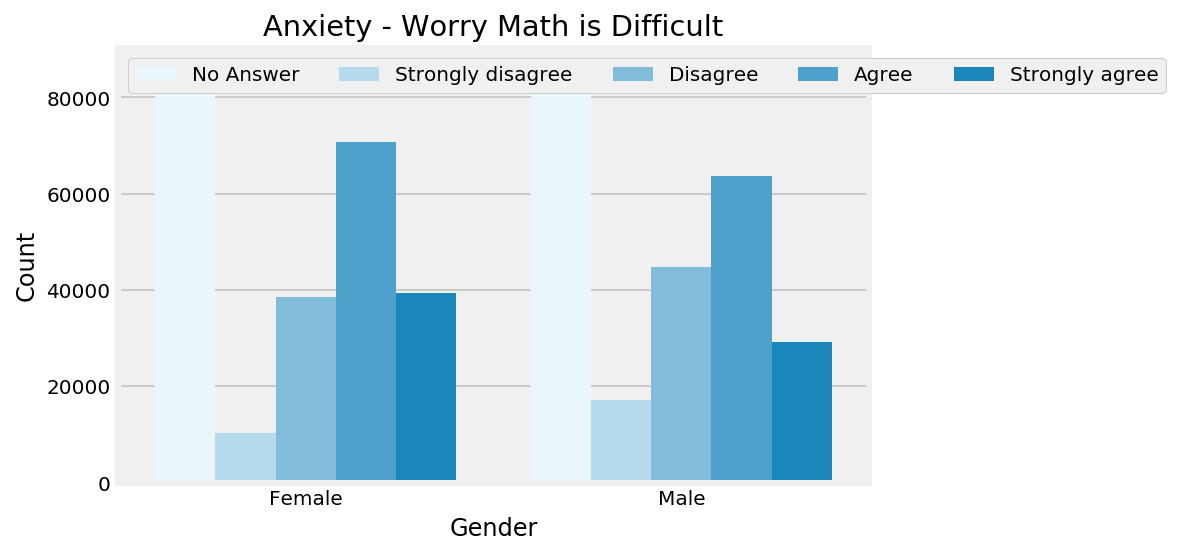

In [41]:
barplot(pisa_df, 'gender', 'ma_worry_that_difficult', 'Count', 'Gender', 
        'Anxiety - Worry Math is Difficult')

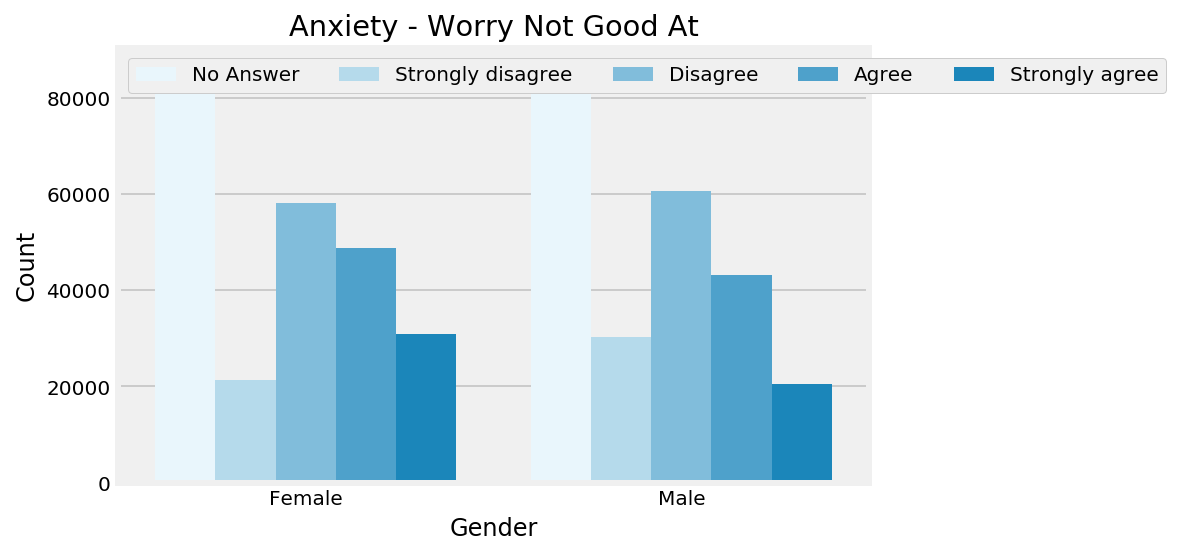

In [42]:
barplot(pisa_df, 'gender', 'msc_worry_not_good_at', 'Count', 'Gender', 'Anxiety - Worry Not Good At')

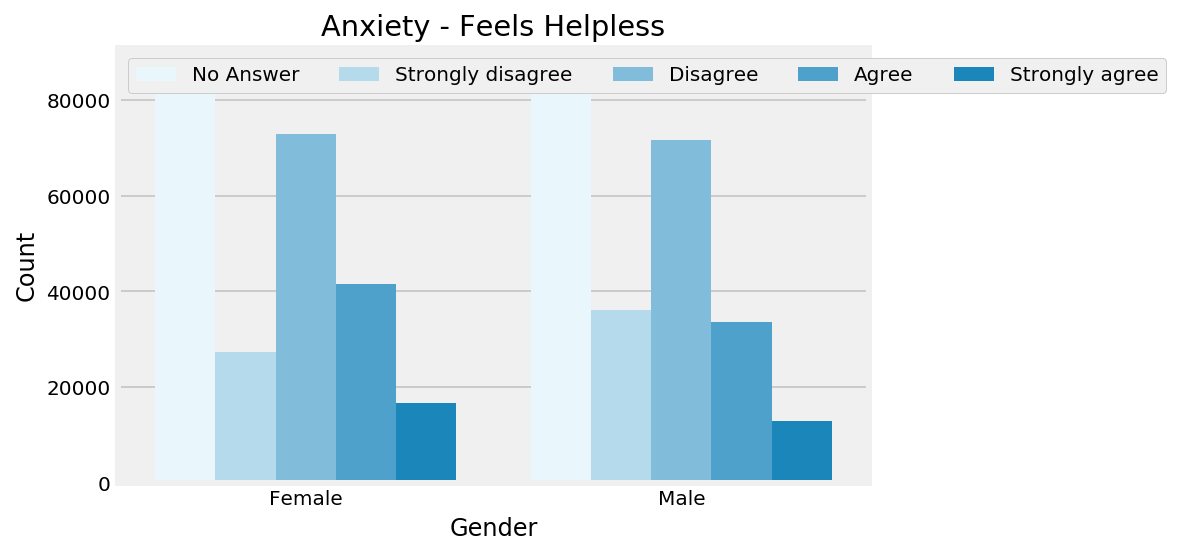

In [43]:
barplot(pisa_df, 'gender', 'ma_feel_helpless', 'Count', 'Gender', 'Anxiety - Feels Helpless')

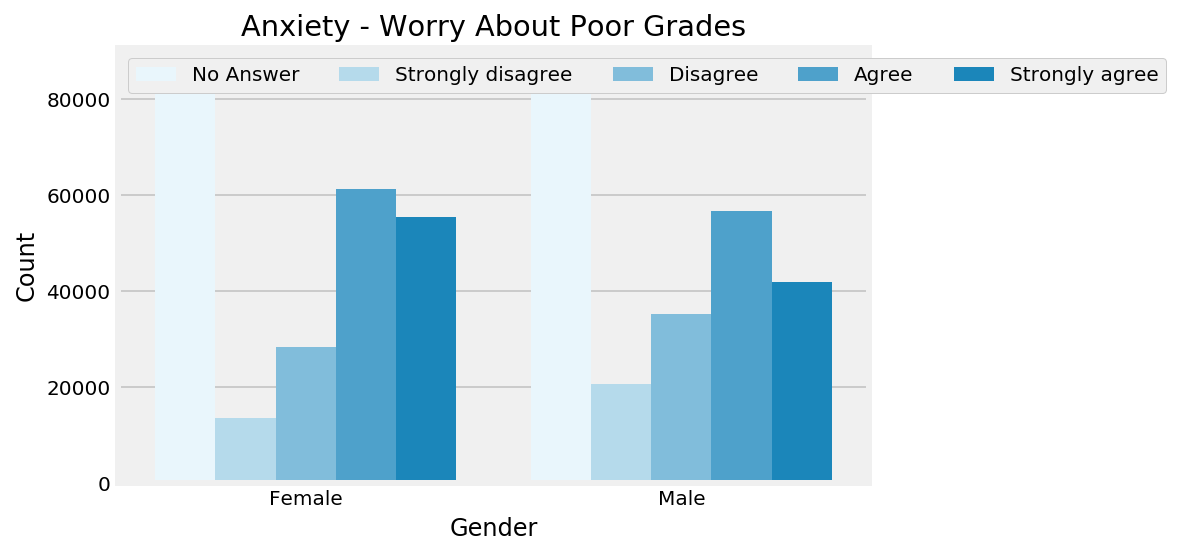

In [44]:
barplot(pisa_df, 'gender', 'ma_worry_about_poor_grades', 'Count', 'Gender', 
        'Anxiety - Worry About Poor Grades')

### There seems to be a clear indication that females are self identifying as having more feelings of anxiety around math. 

## Multivariate Exploration
<a id='multivariate'></a>
I will focus on gender, math scores, and anxiety in this section.

In [45]:
def mbarplot(data, x, y, cvar, ylabel='', xlabel='', title=None):
    # use the supplied dataframe to generate a barplot 
    # chart of multiple values - for multivariate plots
    ax = sb.barplot(data=data,x=x, y=y, hue=cvar);
    ax.legend(loc=8, ncol=2, framealpha=1);
    
    # add annotations
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + (left.get_width()-.05)/2., height_l + 15, '{0:.1%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + (right.get_width()+.05)/2., height_r + 25, '{0:.1%}'.format(height_r/total), ha="center")
    
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if title:
        plt.title(title);
        
    return

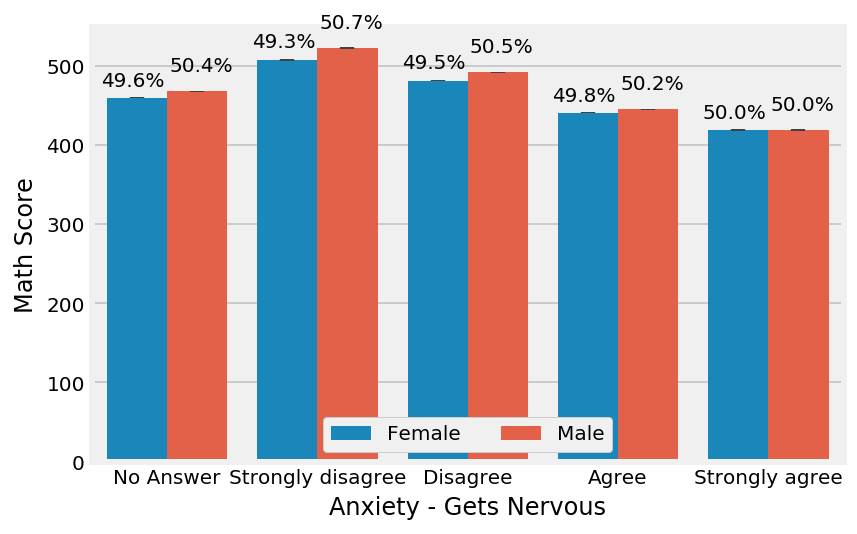

In [46]:
mbarplot(pisa_df, 'ma_get_nervous' , 'math_score', 'gender', 'Math Score', 'Anxiety - Gets Nervous')

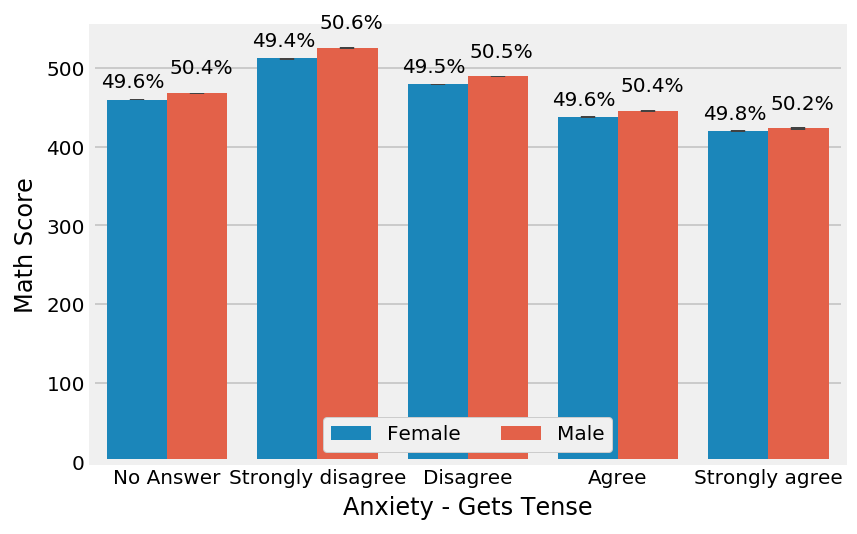

In [47]:
mbarplot(pisa_df, 'ma_get_tense', 'math_score', 'gender', 'Math Score', 'Anxiety - Gets Tense')

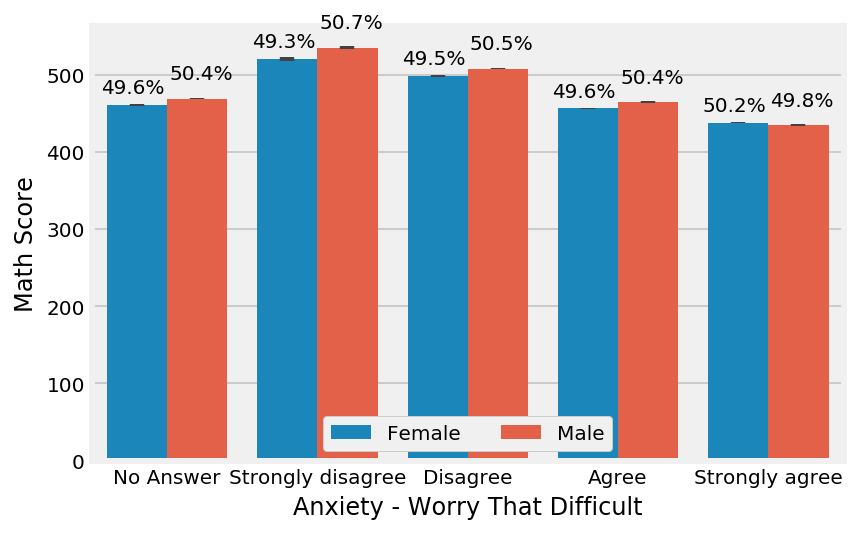

In [48]:
mbarplot(pisa_df, 'ma_worry_that_difficult', 'math_score', 'gender', 'Math Score', 
         'Anxiety - Worry That Difficult')

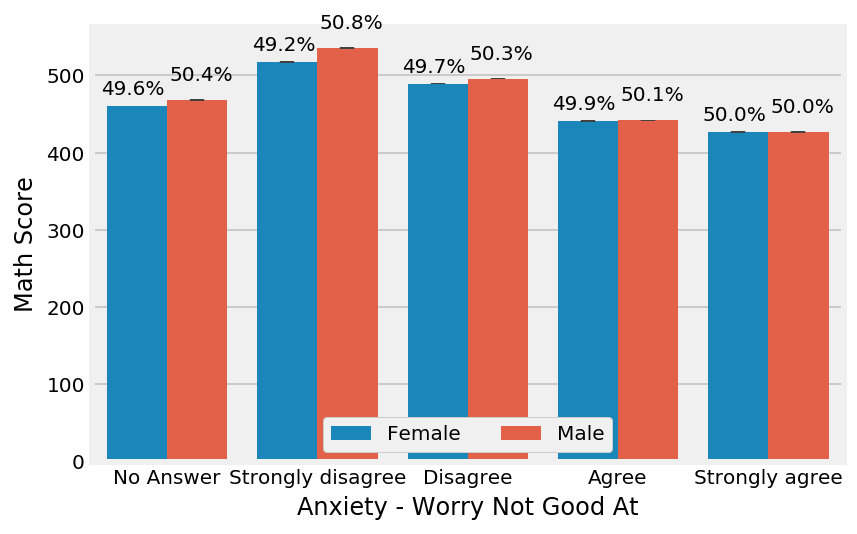

In [49]:
mbarplot(pisa_df, 'msc_worry_not_good_at', 'math_score', 'gender', 'Math Score', 
         'Anxiety - Worry Not Good At')

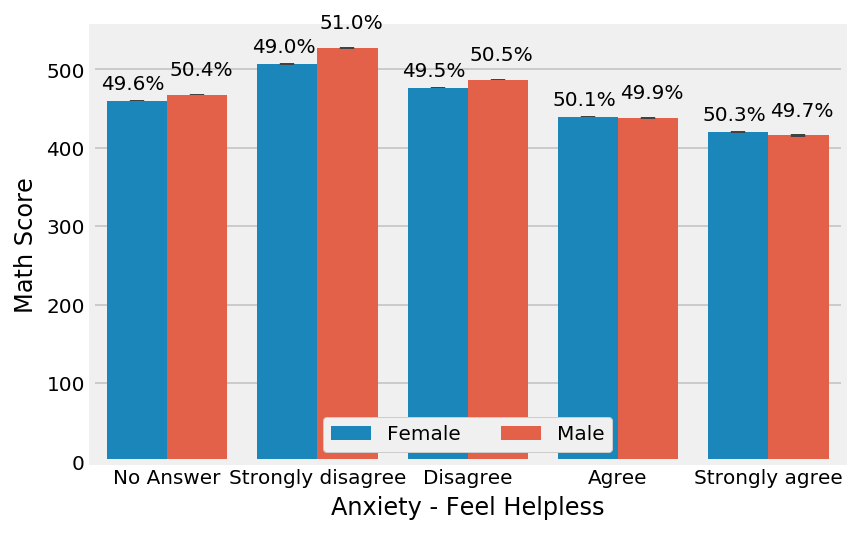

In [50]:
mbarplot(pisa_df, 'ma_feel_helpless', 'math_score', 'gender', 'Math Score', 
         'Anxiety - Feel Helpless')

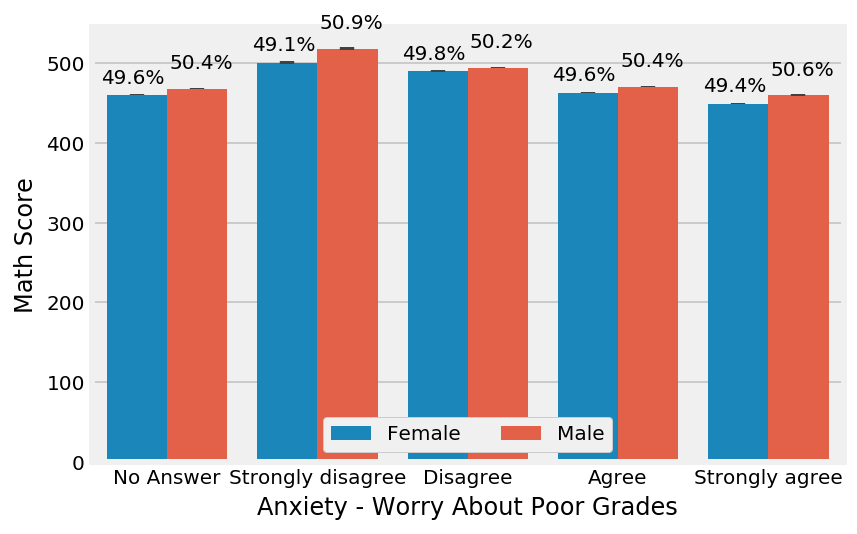

In [51]:
mbarplot(pisa_df, 'ma_worry_about_poor_grades', 'math_score', 'gender','Math Score', 
         'Anxiety - Worry About Poor Grades')

In [52]:
# in order to preserve the categorical columns we need to save
# the data in HDFS format
pisa_df.to_hdf('data/cleaned_pisa.h5', 'table', append=True)

<a id='Summary'></a>
### It seems clear that there is indeed a correlation between a student's feelings of anxiety about math and their test scores. Those students reporting the most anxiety had the lowest test scores, regardless of gender. 



### It seems surprising that there are slightly more males giving affirmation to feelings of anxiety than females, but not by much. It is also surprising that the male students that reported the least amount of anxiety, had higher scores than females who also reported the least amount of anxiety. The reasons for this are not clear and are beyond the scope of this report although I suspect cultural biases where males are more directed towards math and science than females to be part of the reason.

<a id='resources'></a>

### Resources

<ul>
    <li><a href="https://stackoverflow.com">StackOverflow</a></li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#">Pandas Dataframe reference</a></li>
    <li><a href="https://knowledge.udacity.com/?nanodegree=5d1a8326-496f-11e8-b51d-0b52a2c1b841&project=56f678d8-496f-11e8-b3a8-5b814806136d">Udacity Knowledge</a></li>
    <li><a href="https://www.apress.com/us/book/9781484239124">Python Data Analytics</a></li>
    <li><a href="https://www.barnesandnoble.com/w/data-wrangling-with-python-jacqueline-kazil/1126350836?ean=9781491948811">Data Wrangling with Python</a></li>
    <li><a href="https://www.amazon.com/gp/product/1491952962/ref=ppx_yo_dt_b_asin_title_o01_s00?ie=UTF8&psc=1">Practical Statistics for Data Scientists</a></li>
    <li><a href="https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython-ebook/dp/B075X4LT6K/ref=sr_1_fkmr0_1?keywords=O%27Reilley+Python+Data+Wrangling&qid=1554835853&s=gateway&sr=8-1-fkmr0">Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython 2nd Edition</a></li>
    <li><a href="https://www.amazon.com/Pandas-Cookbook-Scientific-Computing-Visualization-ebook/dp/B06W2LXLQK/ref=sr_1_3?keywords=pandas+cookbook&qid=1558657434&s=gateway&sr=8-3">Pandas Cookbook</a></li>
</ul>